In [ ]:
"""
Use movie_data_general_cleaned to build a Linear Regression model for general movies.

Basic feature engineering: scaled features, polynomimal features

functions used:
get_Xy(df) from model.py
get_score(X_train,X_val,y_train,y_val) from model.py

Result: mean of CV R^2 improved compared to baseline model:
from 0.48 to 0.51

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

import patsy
import scipy.stats as stats

import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_2/py')
import importlib
from model import *

## 1. Prepare data

In [2]:
# Load the cleaned complete data
all_df = pd.read_pickle('../data/movie_data_general_cleaned')

# Separate features and target
con_feature = ['budget','runtime','release_year']
cat_feature = ['MPAA','genre','distributor','language','country','keywords']
target_candidate = ['opening_weekend_usa','gross_usa','gross_world','rating','vote']

# Choose only the continuous variables for now
c_movie_df = all_df[['opening_weekend_usa'] + con_feature].copy()

## 2. Basic Feature Engineering

### Split data into Train / Validation / Test sets

In [5]:
# Choose df
# X, y = get_Xy(c_movie_df)
X, y = get_Xy(c_movie_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

### * Scaled Features

In [6]:
# Transform X_train, X_val, X_test separately
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [8]:
# Find scores (R^2) for train set and validation set
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
lr.score(X_train_scaled,y_train), lr.score(X_val_scaled,y_val)

(0.5158105402526112, 0.48979529212513884)

In [14]:
# Find coefficient of each feature
coef = pd.DataFrame(list(zip((['Budget','Release Year','Runtime']),lr.coef_)),\
                    columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)
coef

,Feature,Coefficient
0,Budget,10.709417
2,Runtime,1.097222
1,Release Year,-0.559933


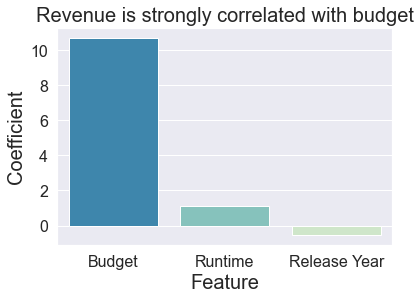

In [15]:
# Generate coef plots for the 3 continuous features

p = sns.color_palette("GnBu_r",3)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.barplot(x="Feature", y= 'Coefficient', data = coef)
ax.set_title('Revenue is strongly correlated with budget',fontsize=20)
ax.set_xlabel('Feature',fontsize=20)
ax.set_ylabel('Coefficient',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

fig.savefig('../plot/lr_coef.pdf', bbox_inches='tight', transparent=True)

In [18]:
# Cross-validation
lr = LinearRegression()
X__scaled = scaler.fit_transform(X_.values)
result = cross_val_score(lr, X__scaled, y_, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

# mean of val_score
print(f"Mean of validation score is: {np.mean(result):.2f} +- {np.std(result):.2f}")
print("All validation scores are", result)

Mean of validation score is: 0.51 +- 0.04
All validation scores are [0.50378666 0.45973472 0.52541686 0.5788602  0.47011523]


### * Polynomial Fearues
(degree=2): Adding interaction terms and second order feature.

In [19]:
X, y = get_Xy(c_movie_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

#### A. Only adding interaction terms

In [35]:
poly = PolynomialFeatures(degree=2,interaction_only = True)

X_train_poly_scaled = scaler.fit_transform(poly.fit_transform(X_train))
X_val_poly_scaled = scaler.transform(poly.transform(X_val))

lr.fit(X_train_poly_scaled,y_train)
lr.score(X_train_poly_scaled,y_train), lr.score(X_val_poly_scaled,y_val)

(0.5190274835985376, 0.4942371622965954)

In [23]:
# Cross-validation
lr = LinearRegression()
X__poly_scaled = scaler.fit_transform(poly.fit_transform(X_))
result = cross_val_score(lr, X__poly_scaled, y_, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

# mean of val_score
print(f"Mean of validation score is: {np.mean(result):.2f} +- {np.std(result):.2f}")
print("All validation scores are", result)

Mean of validation score is: 0.51 +- 0.04
All validation scores are [0.50852269 0.45815389 0.52840767 0.58136603 0.4716393 ]


#### B. Including squared terms

In [43]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = False)

X_train_poly_scaled = scaler.fit_transform(poly.fit_transform(X_train))
X_val_poly_scaled = scaler.transform(poly.transform(X_val))

lr.fit(X_train_poly_scaled,y_train)
lr.score(X_train_poly_scaled,y_train), lr.score(X_val_poly_scaled,y_val)

(0.520129788499761, 0.4928705454773836)

In [38]:
# Cross-validation
lr = LinearRegression()
X__poly_scaled = scaler.fit_transform(poly.fit_transform(X_))
result = cross_val_score(lr, X__poly_scaled, y_, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

# mean of val_score
print(f"Mean of validation score is: {np.mean(result):.2f} +- {np.std(result):.2f}")
print("All validation scores are", result)

Mean of validation score is: 0.51 +- 0.04
All validation scores are [0.51026808 0.4568673  0.52665696 0.58043823 0.4725812 ]


In [25]:
# Train R^2 increased but a little but Val R^2 dropped a little
# But overall similir

In [48]:
# Find coefficient of each feature
feature = poly.get_feature_names(con_feature)
coef = pd.DataFrame(list(zip((feature),lr.coef_)),columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)
coef

,Feature,Coefficient
6,budget release_year,155.501910
2,runtime,47.199315
9,release_year^2,41.103588
5,budget runtime,4.395566
0,1,0.000000
4,budget^2,-0.472781
7,runtime^2,-2.655639
3,release_year,-39.042598
8,runtime release_year,-45.861857
1,budget,-148.252639


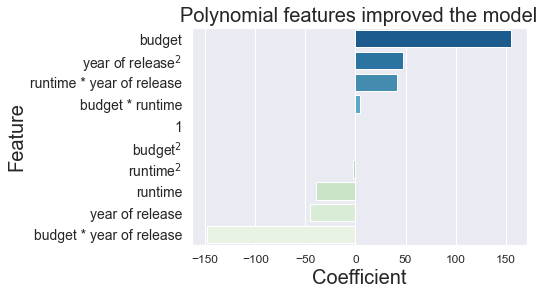

In [56]:
# Generate coef plots for the 3 continuous features

p = sns.color_palette("GnBu_r",10)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.barplot(y="Feature", x= 'Coefficient', data = coef,orient='h')
ax.set_title('Polynomial features improved the model',fontsize=20)
ax.set_ylabel('Feature',fontsize=20)
ax.set_xlabel('Coefficient',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)

ax.set_yticklabels(['budget','year of release$^2$','runtime * year of release','budget * runtime','1',\
                    'budget$^2$','runtime$^2$','runtime','year of release','budget * year of release'])

fig.savefig('../plot/lr_poly_coef.pdf', bbox_inches='tight', transparent=True)


Train R^2 score was: 0.520129788499761
Validation R^2 score was: 0.4928705454773836
RMSE: 10.83 



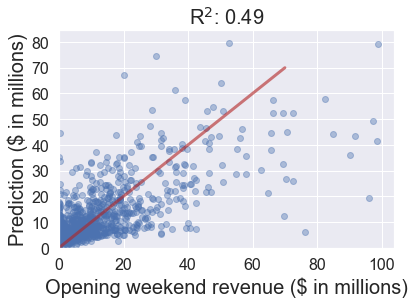

In [66]:
fig,lr,y_pred = get_score(X_train_poly_scaled,X_val_poly_scaled,y_train,y_val)

In [63]:
fig.savefig('../plot/lr_poly_prediction.pdf', bbox_inches='tight', transparent=True)

### Residuals

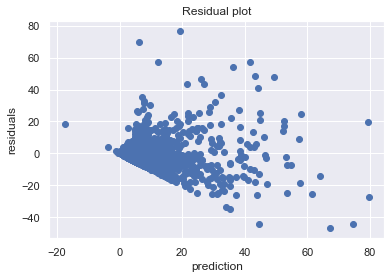

In [64]:
res = y_val - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals");

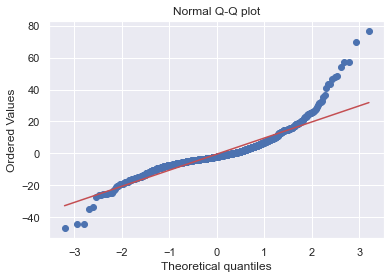

In [65]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [ ]:
# still right skew/ heavily tailed